In [1]:
from geom2vec.data import Preprocessing
import torch

folder_path = '/project/dinner/zpengmei/geom2vec/results/chignolin_stride10'
preprocess = Preprocessing(torch_or_numpy='torch')
raw_dataset = preprocess.load_dataset(data_path=folder_path,mmap_mode='r')
# we concatenate the data of the same trajectory
dataset = torch.cat(raw_dataset).sum(1)

# read the data
import scipy
import numpy as np

data = np.load("/project/dinner/zpengmei/geom2vec/tutorial/data/chignolin/chignolin.npz")
ca_rmsds = data['ca_rmsds']
qtots = data['qtots']
end_end_dists = data['end_end_dists']
ca_dists = data['ca_dists']
chi1s = data['chi1s']
trp_psi = data['trp_psi']
tics = data['tics']

assert len(ca_rmsds) == len(qtots) == len(end_end_dists) == len(ca_dists) == len(chi1s) == len(trp_psi) == len(tics) == len(dataset)

# define the state
dtype = torch.float32

ca_rmsd_arr = ca_rmsds * 10
smoothed_qtots = scipy.signal.convolve(qtots, np.ones(50) / 50, mode="same")
end_end_arr = end_end_dists * 10
folded = ((((smoothed_qtots - 0.5)**2 / 0.1**2) + ((ca_rmsd_arr - 1)**2)) < 1) & (chi1s[:, 5] > 0) & (trp_psi > 0)
unfolded = (smoothed_qtots < 0.1) & (ca_rmsd_arr > 3) & (end_end_arr > 10) & (tics[:, 1] < -1)

label_traj = np.zeros(len(folded))
label_traj[folded] = 2
label_traj[unfolded] = 3
transitions = np.nonzero(np.diff(label_traj))[0]
print(label_traj[:20])
print(transitions[:20])
print(np.diff(label_traj)[transitions][:20])
diff_transitions = np.diff(label_traj)[transitions]
# folded, D, unfolded gives -2, 3, sum is 1
print(np.count_nonzero((diff_transitions[:-1] == -2) & (diff_transitions[1:] == 3)))
# unfolded, D, folded gives -3, 2, sum is -1
print(np.count_nonzero((diff_transitions[1:] + diff_transitions[:-1]) == -1))

guess_f = torch.tensor(folded, dtype=dtype).unsqueeze(-1)
in_d = torch.tensor(~(folded | unfolded), dtype=dtype).unsqueeze(-1)
in_a = torch.tensor(unfolded, dtype=bool).unsqueeze(-1)
in_b = torch.tensor(folded, dtype=bool).unsqueeze(-1)
print(in_d.shape)


/project/dinner/zpengmei/conda_envs/torch/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 519.58it/s]


[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
[ 24  25  33  34  55  56  64  65  67  68  87 120 138 145 160 198 206 207
 211 222]
[-3.  3. -3.  3. -3.  3. -3.  3. -3.  3. -3.  2. -2.  2. -2.  2. -2.  2.
 -2.  2.]
33
34
torch.Size([53475, 1])


In [2]:
stop_dataset = preprocess.create_time_lagged_stop_dataset(data=dataset,ina=in_a, inb=in_b, lag_time=10)

In [4]:
from torch.utils.data.dataloader import DataLoader

train_data, val_data = torch.utils.data.random_split(stop_dataset, [int(0.8*len(stop_dataset)), len(stop_dataset)-int(0.8*len(stop_dataset))])

print('train_data:', len(train_data))
print('val_data:', len(val_data))

train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_data, batch_size=1000, shuffle=False)

for data, data2, ind_stop in train_loader:
    print(
        data.shape,
        data2.shape,
        ind_stop.shape
    )
    break

train_data: 42772
val_data: 10693
torch.Size([1000, 4, 128]) torch.Size([1000, 4, 128]) torch.Size([1000, 1])


In [12]:
from geom2vec.downstream_models.vamp.stopvampnet import  StopVAMPNet
from geom2vec import Lobe

# define the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = Lobe(
    hidden_channels=128,
    intermediate_channels=128,
    output_channels=2,
    num_layers=3,
    batch_norm=False,
    vector_feature=True,
    mlp_dropout=0.1,
    mlp_out_activation=None,
    device=device,
)

model = StopVAMPNet(
    lobe=net,
    learning_rate=1e-4,
    device=device
)

model.fit(train_loader=train_loader, n_epochs=5,validation_loader=val_loader)

epoch:  20%|████████████████████████▍                                                                                                 | 1/5 [00:00<00:01,  2.65it/s]

0 1.2737425565719604


epoch:  40%|████████████████████████████████████████████████▊                                                                         | 2/5 [00:00<00:01,  2.70it/s]

1 1.3009573221206665


epoch:  60%|█████████████████████████████████████████████████████████████████████████▏                                                | 3/5 [00:01<00:00,  2.70it/s]

2 1.3097480535507202


epoch:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4/5 [00:01<00:00,  2.69it/s]

3 1.3140869140625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 92.22it/s]
                                                                                                                                                                    

4 1.317591667175293


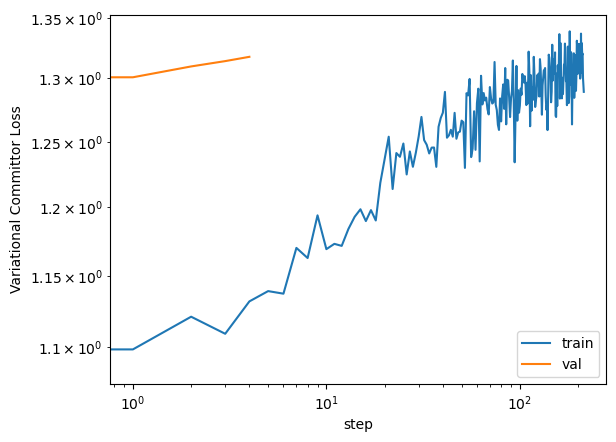

In [13]:
train_score = model.training_scores
val_score = model.validation_scores

import matplotlib.pyplot as plt

plt.loglog(train_score, label='train')
plt.loglog(val_score, label='val')
plt.xlabel('step')
plt.ylabel('Variational Committor Loss')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:00<00:00, 1272.66it/s]


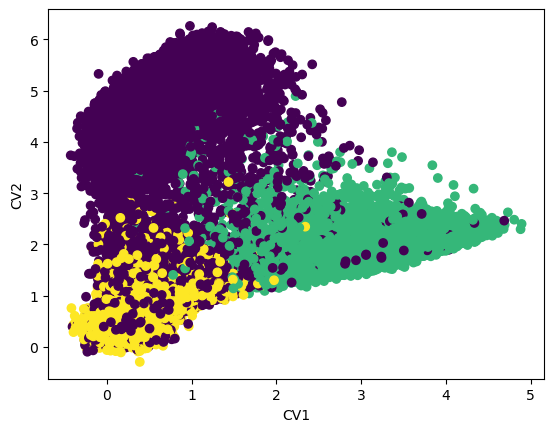

In [14]:
import matplotlib.pyplot as plt
cvs = model.transform(dataset,batch_size=1000)

plt.scatter(cvs[:, 0], cvs[:, 1], c=label_traj, cmap='viridis')
plt.xlabel('CV1')
plt.ylabel('CV2')
plt.show()
